In [ ]:
import numpy as np
from Scripts.utils import *
from Scripts.analytical_solutions import bernardes_eq, markov_approach, including_fusion

import networkx as nx
from Scripts.shortest_path import monte_carlo

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns

from rich.progress import track

In [2]:
#Constants
vertices = 8
sim_count = 10000

So the grid would look like,

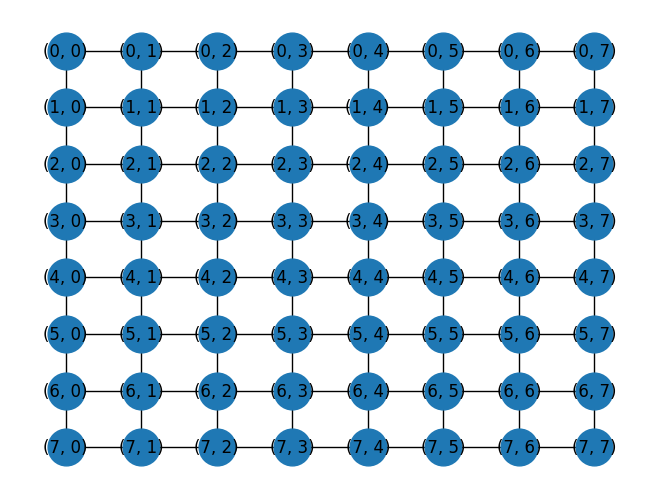

In [3]:
G = nx.grid_2d_graph(vertices, vertices)
pos = {(x, y): (y, -x) for x, y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=700)

Before we present our novel results which include fusion, we recreate the published results for non-deterministic (p < 1) entanglement generation success and non-deterministic swap. The first has been published by Bernades et al and the second by Shchukin and Brand independently.

##### Non-deterministic p

In [4]:
p = 0.1; q = 1; k = 1
bernades = bernardes_eq(manhattan_distance(vertices), p)
mc = monte_carlo(vertices, sim_count, sim_count, p, 1, 1)

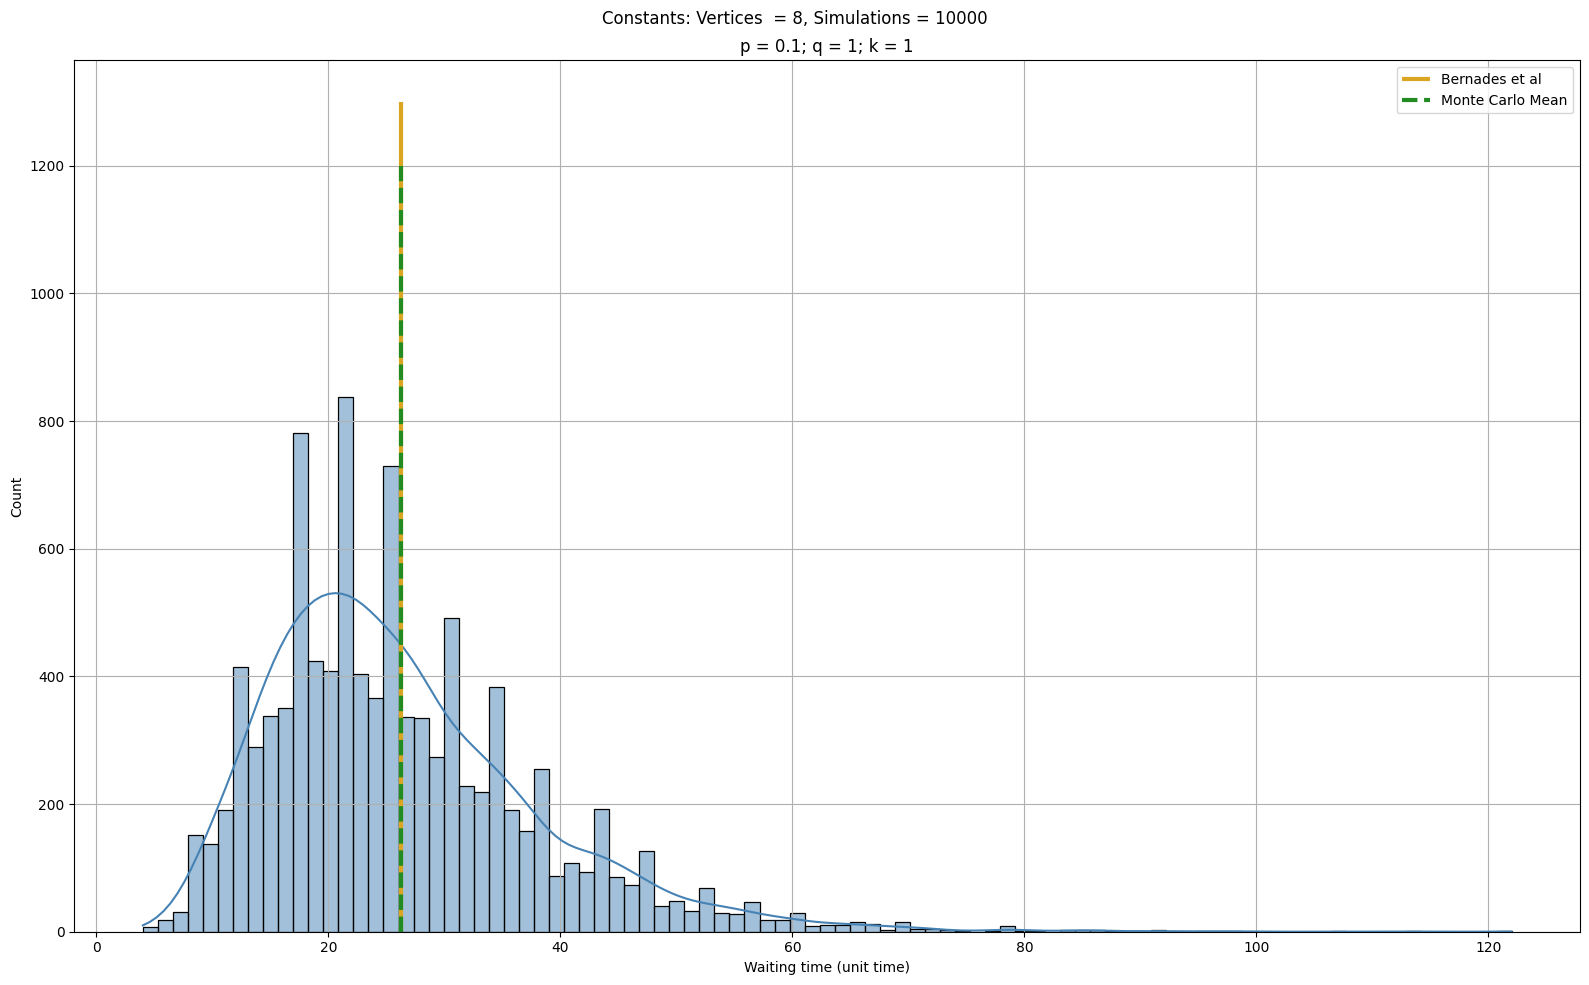

In [5]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.histplot(mc, ax = ax, kde = True, color = 'steelblue')
ax.vlines(bernades, 0, 1300, colors='goldenrod', label = 'Bernades et al', linewidth = 3)
ax.vlines(np.mean(mc), 0, 1200, colors='forestgreen', label = 'Monte Carlo Mean', linewidth = 3, linestyle = "dashed")
ax.set_xlabel("Waiting time (unit time)")
ax.set_ylabel("Count")
ax.set_title(f"p = {p}; q = {q}; k = {k}")
ax.legend(loc = 'best')
ax.grid(True)


plt.suptitle(f"Constants: Vertices  = {vertices}, Simulations = {sim_count}")

plt.tight_layout()

We clearly see that the Monte-Carlo simulation provided by Brand works well with non-deterministic $p$.

##### Non-deterministic p & q

In [6]:
p = 0.1
q = 0.9
k = 1

mc = monte_carlo(vertices, sim_count, sim_count, p, q, k)

shchukin_vals = markov_approach(vertices, p, q)

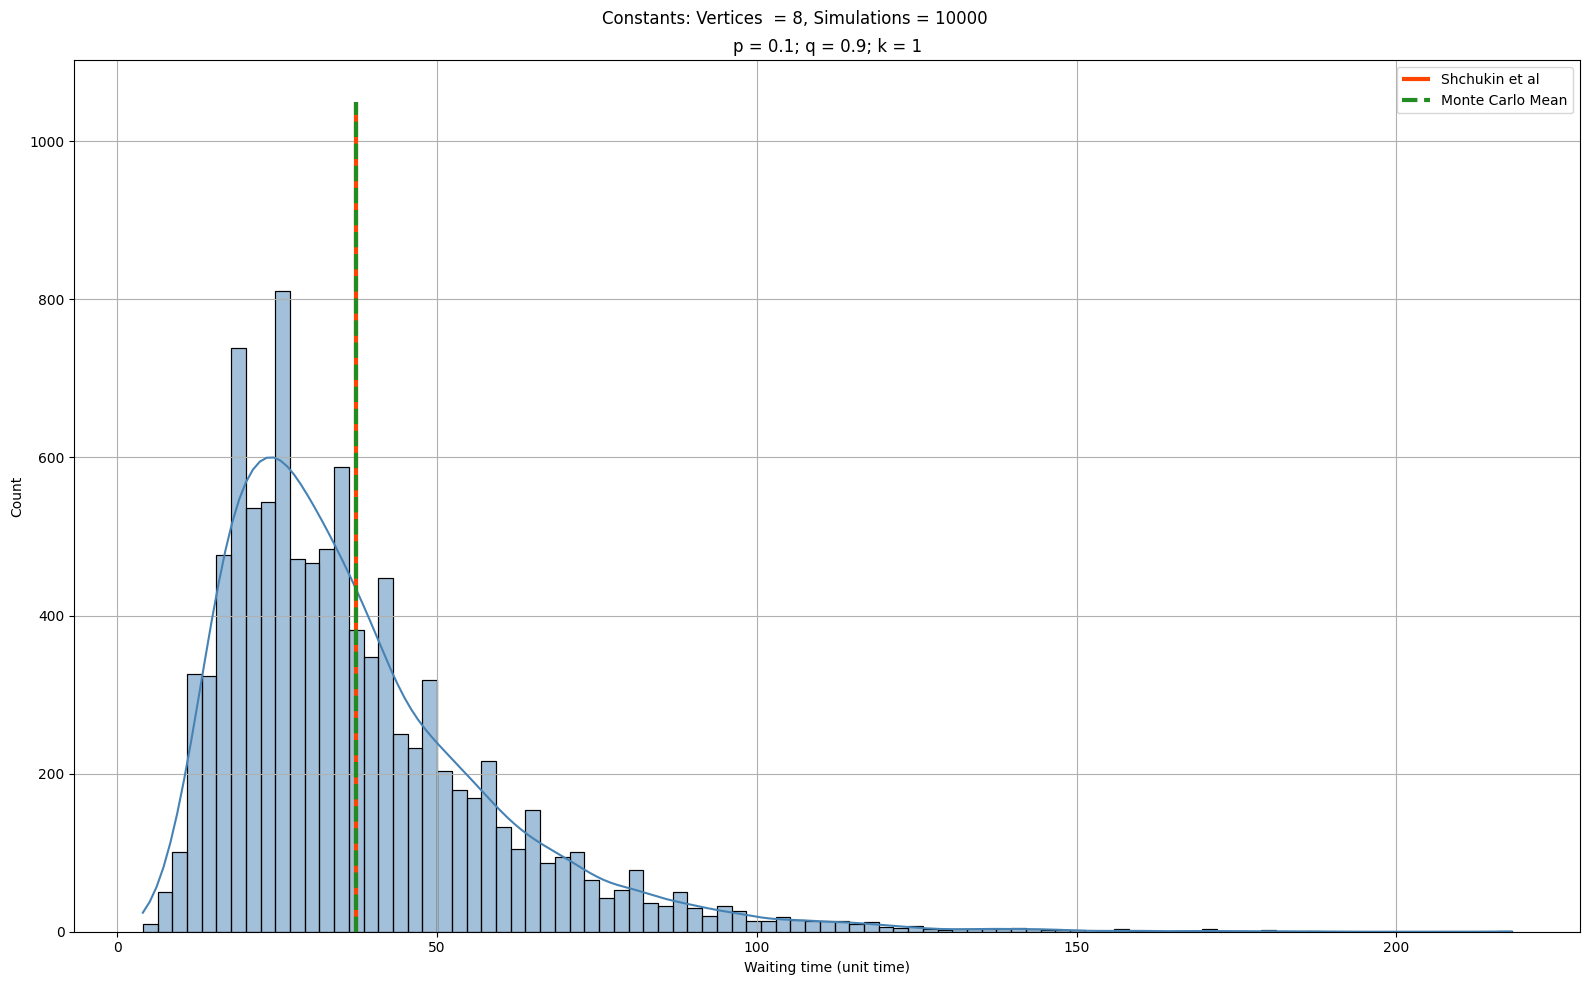

In [7]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.histplot(mc, ax = ax, kde = True, color = 'steelblue')
ax.vlines(shchukin_vals, 0, 1050, colors ='orangered', label = 'Shchukin et al', linewidth = 3)
ax.vlines(np.mean(mc), 0, 1050, colors='forestgreen', label = 'Monte Carlo Mean', linewidth = 3, linestyle = "dashed")
ax.set_xlabel("Waiting time (unit time)")
ax.set_ylabel("Count")
ax.set_title(f"p = {p}; q = {q}; k = {k}")
ax.legend(loc = 'best')
ax.grid(True)

plt.suptitle(f"Constants: Vertices  = {vertices}, Simulations = {sim_count}")

plt.tight_layout()

Clearly, we see that the Shchukin model and the Brand model (which we will now call the Markov Chain and the Monte-Carlo simulation), align well for the stated values of the number of segments.

##### Including Fusion

We now present our novel solution introducing fusion to the Markov Chain and Monte-Carlo simulations. Further we will present some other methods of quantifying the latency, with the different of the new approach having an experimental base rather than theoretical.

In [8]:
p = 0.1
q = 0.9
k = 0.3

mc = monte_carlo(vertices, sim_count, sim_count, p, q, k)
fusion_vals = including_fusion(vertices, p, q, k)

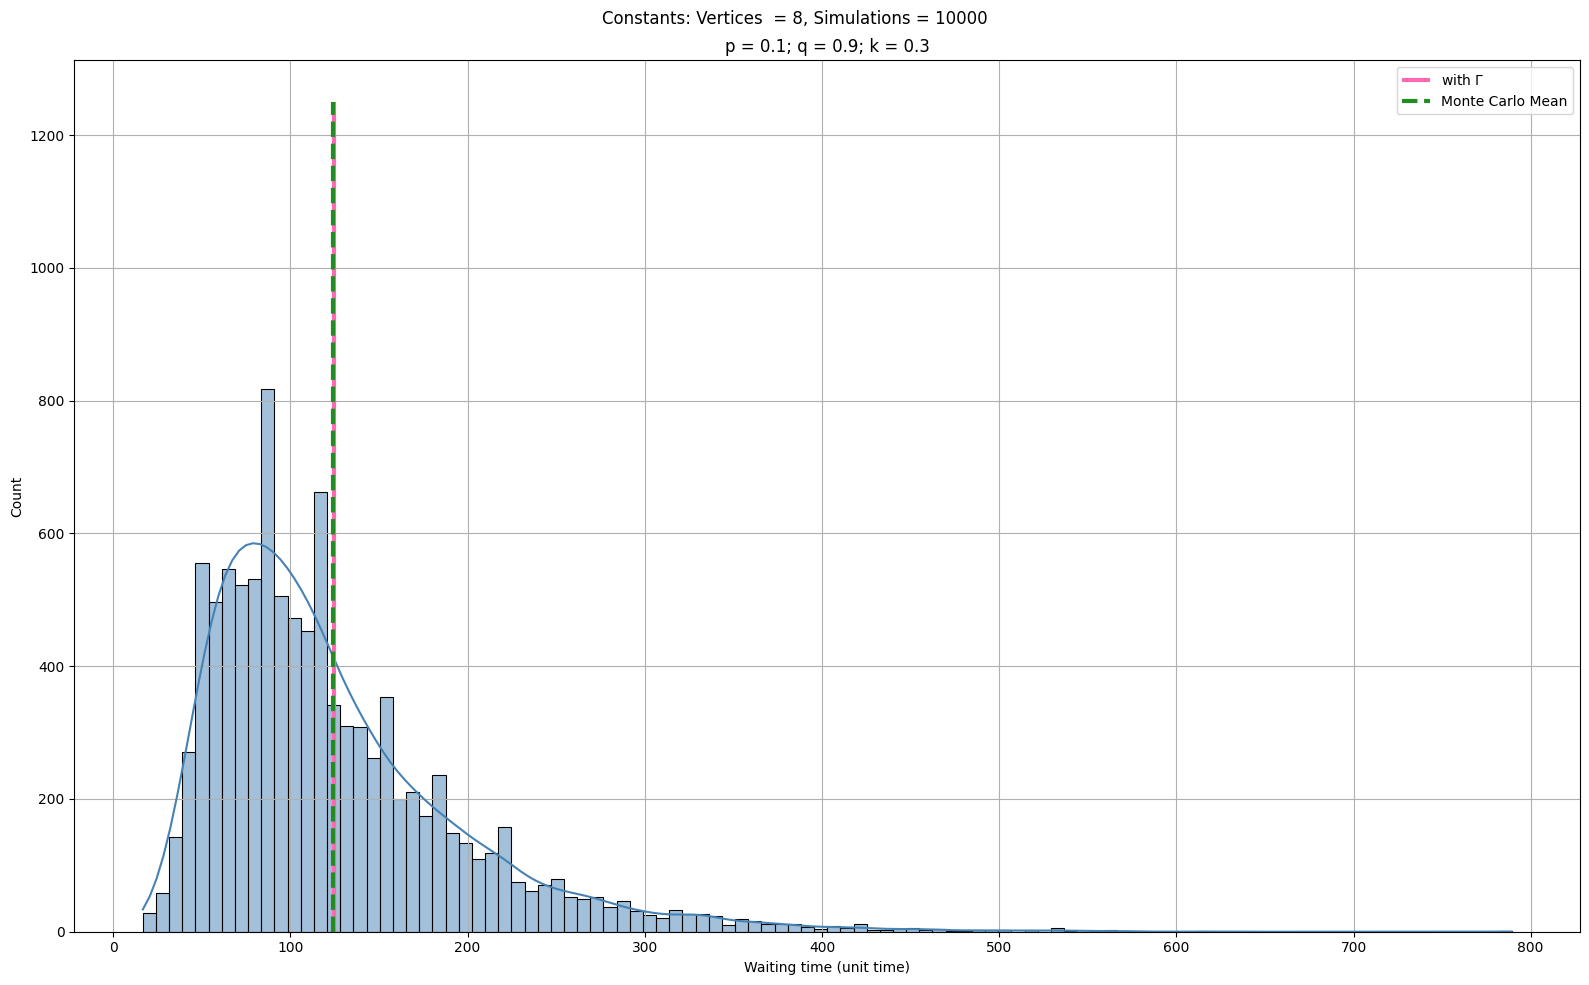

In [9]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.histplot(mc, ax = ax, kde = True, color = 'steelblue')
ax.vlines(fusion_vals, 0, 1250, colors ='hotpink', label = r'with $\Gamma$', linewidth = 3)
ax.vlines(np.mean(mc), 0, 1250, colors='forestgreen', label = 'Monte Carlo Mean', linewidth = 3, linestyle = "dashed")
ax.set_xlabel("Waiting time (unit time)")
ax.set_ylabel("Count")
ax.set_title(f"p = {p}; q = {q}; k = {k}")
ax.legend(loc = 'best')
ax.grid(True)


plt.suptitle(f"Constants: Vertices  = {vertices}, Simulations = {sim_count}")

plt.tight_layout()

Once we have gained confidence that our model maps fusion properly, we can introduce the experimentally based method.

##### Evaluating the time taken in classical communication and quantum operations

In [10]:
#First we define all the deterministic variables

q = 0.7
k = 0.5

def p_l(L):
    p_0 = 0.0018
    return p_0*10**((-0.2*L)/10)

c = 299792.458/1.4585 

t_ent = 123e-6
t_swap = 2157e-6
t_fusion = 300e-6

In [11]:
# Then we can simulate the timing distribution returning the number of attempts in entanglement, swapping and fusion.

def quantum_operations_count(l, quantum_times: tuple, p, q, k):
    _, this_np, this_nq, this_nk = monte_carlo(vertices, sim_count, sim_count, p, q, k, ind = True)

    classical_contribution_ent = np.array(np.mean(this_np)*2*(vertices-1))*(l/c)
    classical_contribution_swap = np.array(np.mean(this_nq)*2*(vertices-2))*(l/c)

    classical_contribution = [classical_contribution_ent, classical_contribution_swap]
    
    quantum_contribution_ent = np.array(np.mean(this_np)*(quantum_times[0] + l/(2*c)))
    quantum_contribution_swap = np.array(np.mean(this_nq)*quantum_times[1])
    quantum_contribution_fusion = np.array(np.mean(this_nk)*quantum_times[2])

    quantum_contribution = [quantum_contribution_ent, quantum_contribution_swap, quantum_contribution_fusion]


    #time error calculations
    classical_contribution_ent_dev = np.array(np.std(this_np)*2*(vertices-1))*(l/c)
    classical_contribution_swap_dev = np.array(np.std(this_nq)*2*(vertices-2))*(l/c)

    quantum_contribution_ent_dev = np.array(np.std(this_np)*(quantum_times[0] + l/(2*c)))
    quantum_contribution_swap_dev = np.array(np.std(this_nq)*quantum_times[1])
    quantum_contribution_fusion_dev = np.array(np.std(this_nk)*quantum_times[2])

    this_error = sum([classical_contribution_ent_dev,
                      classical_contribution_swap_dev,
                      quantum_contribution_ent_dev,
                      quantum_contribution_swap_dev,
                       quantum_contribution_fusion_dev])


    return classical_contribution, quantum_contribution, this_error

In [12]:
# Generate the data
distances_1 = [i for i in range(1, 10, 1)]
distances_2 = [i for i in range(10, 20, 2)]
distances_f = [j for j in range(20, 30, 3)]

distances = distances_1 + distances_2 + distances_f

res = np.zeros(shape = (len(distances), 5))
errors = np.zeros(shape = len(distances))
marker = 0
for i in track(distances):
    cla, qua, err = quantum_operations_count(i, (t_ent, t_swap, t_fusion), p_l(i), q, k)
    res[marker, 0] = cla[0]
    res[marker, 1] = cla[1]
    res[marker, 2] = qua[0]
    res[marker, 3] = qua[1]
    res[marker, 4] = qua[2]
    errors[marker] = err
    marker += 1


res_copy = np.copy(res)

for i, d in enumerate(res):
    res[i, :] = normalize_array(d)

Output()

Text(0.5, 0, 'Distance between nodes (km)')

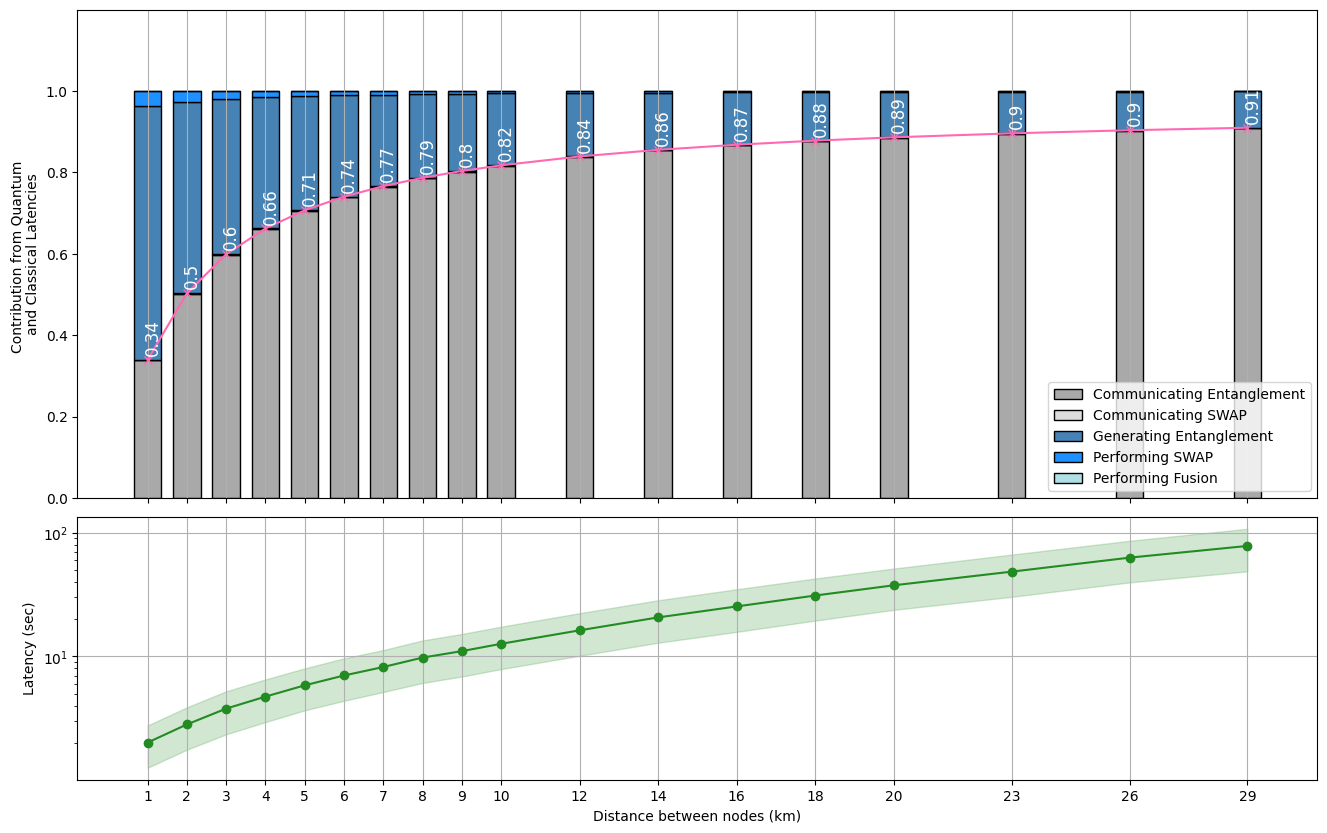

In [13]:
colors = ["darkgray", "gainsboro", "steelblue", "dodgerblue", "powderblue"]
labels = ["Communicating Entanglement", "Communicating SWAP", "Generating Entanglement", "Performing SWAP", "Performing Fusion",]

done_labels = []

fig, ax = plt.subplots(2, 1, figsize = (16, 10), sharex=True, height_ratios=[0.65, 0.35])

fig.subplots_adjust(hspace=0.05)

for u in range(len(distances)):
    heights = res[u]

    ax[0].bar(distances[u], heights[0], width = 0.7, color=colors[0], edgecolor = 'black', label=labels[0] if labels[0] not in done_labels else "")
    bottom = heights[0]
    done_labels.append(labels[0])

    for i in range(1, len(heights)):
        ax[0].bar(distances[u], heights[i], width = 0.7, bottom=bottom, color=colors[i], edgecolor = 'black', label=labels[i] if labels[i] not in done_labels else "")
        bottom += heights[i]
        done_labels.append(labels[i])

for t in range(len(distances)):
        ax[0].text(distances[t]-0.1, res[t, 0] +  res[t, 1] + 0.02, f"{np.round(res[t, 0] +  res[t, 1], 2)}", rotation = 90, color = 'white', fontsize = 12)

ax[0].plot(distances, res[:, 0] +  res[:,1], marker = 'x', color = 'hotpink')

ax[0].legend(loc = 'best')

ax[0].set_ylabel('Contribution from Quantum \nand Classical Latencies', multialignment = 'center')
ax[0].legend(loc = 'best')
ax[0].xaxis.grid(True)
ax[0].tick_params('x', labelbottom=False)
ax[0].set_ylim(0., 1.2)

ax[0].set_yticks(np.arange(0., 1.2, 0.2), [0., 0.2, 0.4, 0.6, 0.8, 1.0])

ax[1].plot(distances, [sum(arr) for arr in res_copy], color = 'forestgreen', marker = 'o')
ax[1].grid(True)
ax[1].set_yscale('log')
ax[1].set_ylabel('Latency (sec)')
ax[1].set_xticks(distances, distances)

ax[1].fill_between(distances, [sum(arr) - errors[i]/2 for i, arr in enumerate(res_copy)], 
                 [sum(arr) + errors[i]/2 for i, arr in enumerate(res_copy)], alpha = 0.2, color = 'forestgreen')
ax[1].set_xlabel('Distance between nodes (km)')